In [1]:
import sys
import importlib
import gc
import glob
from itertools import combinations

import numpy as np
import jax
from jax import random
import jax.numpy as jnp
import sklearn

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns

In [2]:
print(jax.devices())
print(jax.__version__)

0.2.25


In [3]:
plt.style.use("custom")  # custom style sheet
plt.style.use("muted")  # muted color theme from SciencePlots

In [4]:
cm_seq = sns.cubehelix_palette(
    start=0, rot=-0.70, gamma=0.40, light=0.9, dark=0.1, as_cmap=True, reverse=True
)
colors = mpl.colors.to_rgba_array(
    [
        "#364B9A",
        "#4A7BB7",
        "#6EA6CD",
        "#98CAE1",
        "#C2E4EF",
        "#EAECCC",
        "#FEDA8B",
        "#FDB366",
        "#F67E4B",
        "#DD3D2D",
        "#A50026",
    ]
)
cm_div = mpl.colors.LinearSegmentedColormap.from_list("", colors)

In [5]:
@jax.jit
def loss(W, Z):
    return (
        jnp.linalg.norm(W @ Z - X) ** 2 / n
    )  # + lmbda * jnp.sum(jnp.abs(W)) # + κ * sum(X.^2)

In [6]:
def project(W):
    # projection of rows of W onto the simplex using the Bregman divergence
    return W / jnp.sum(W, axis=1, keepdims=True)

In [7]:
def pgd(What, Zhat, eta, max_iter):
    loss_hist = [loss(What, Zhat)]
    #     W_hist = [jnp.linalg.norm(W - What, ord=jnp.inf)] # max absolute sum of columns
    #     Z_hist = [jnp.linalg.norm(Z - Zhat)]

    grad = jax.jit(jax.grad(loss, argnums=(0, 1)))

    for it in range(max_iter):
        dW, dZ = grad(What, Zhat)

        diff = What - eta * dW
        What = project(jnp.where(diff > 0, x=diff, y=0))
        Zhat -= eta * dZ

        # Bregman divergence update rule
        #         What = project(What * jnp.exp(-eta * dW))
        #         Zhat = Zhat * jnp.exp(-eta * dZ)

        loss_hist.append(loss(What, Zhat))
        #         W_hist.append(jnp.linalg.norm(W - What, ord=jnp.inf))
        #         Z_hist.append(jnp.linalg.norm(Z - Zhat))
        if it % 1000 == 999:
            print(f"Finished iteration {it + 1}")

    return What, Zhat, loss_hist

In [8]:
def onehot(i, n):
    """
    One-hot basis vector of length n with ith entry.
    """
    e = jnp.zeros(n)
    e.at[1].set(1)
    return e

# Test

In [9]:
# test
n = 200
K = 3
d = 2
key = random.PRNGKey(123)
key, *subkeys = random.split(key, 6)

In [10]:
Z = 5 * random.normal(subkeys[0], shape=(K, d))
assignments = random.choice(subkeys[1], jnp.arange(K), shape=(n,))
W = jax.nn.one_hot(assignments, K)

X = W @ Z + 1 * random.normal(subkeys[2], shape=(n, d))

In [11]:
X.shape

(200, 2)

In [31]:
bounds = [0, 1, 2, 3]
norm = mpl.colors.BoundaryNorm(bounds, cm_div.N)

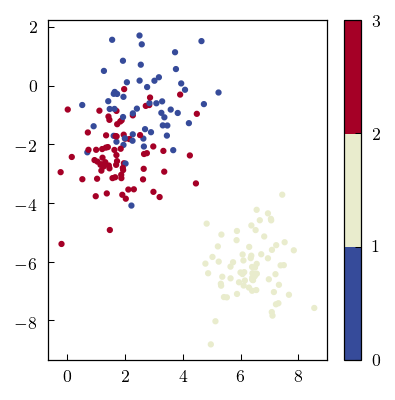

In [32]:
plt.scatter(*X.T, c=assignments.astype(int), cmap=cm_div, norm=norm)
plt.colorbar()

In [13]:
W0 = random.normal(subkeys[3], shape=(n, K))
Z0 = random.normal(subkeys[4], shape=(K, d))
What = project(W0)
What, Zhat, loss_hist = pgd(What, Z0, 1e-2, 2500)

Finished iteration 1000
Finished iteration 2000


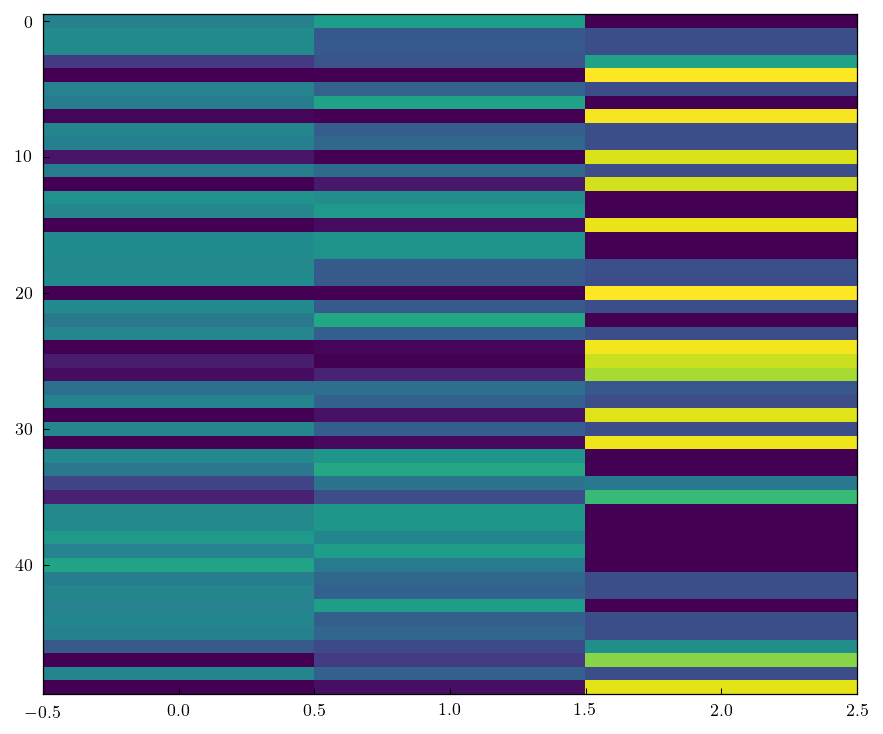

In [77]:
plt.figure(figsize=(7, 6))
plt.imshow(What[:50], aspect="auto", interpolation="none")

NameError: name 'W_hist' is not defined

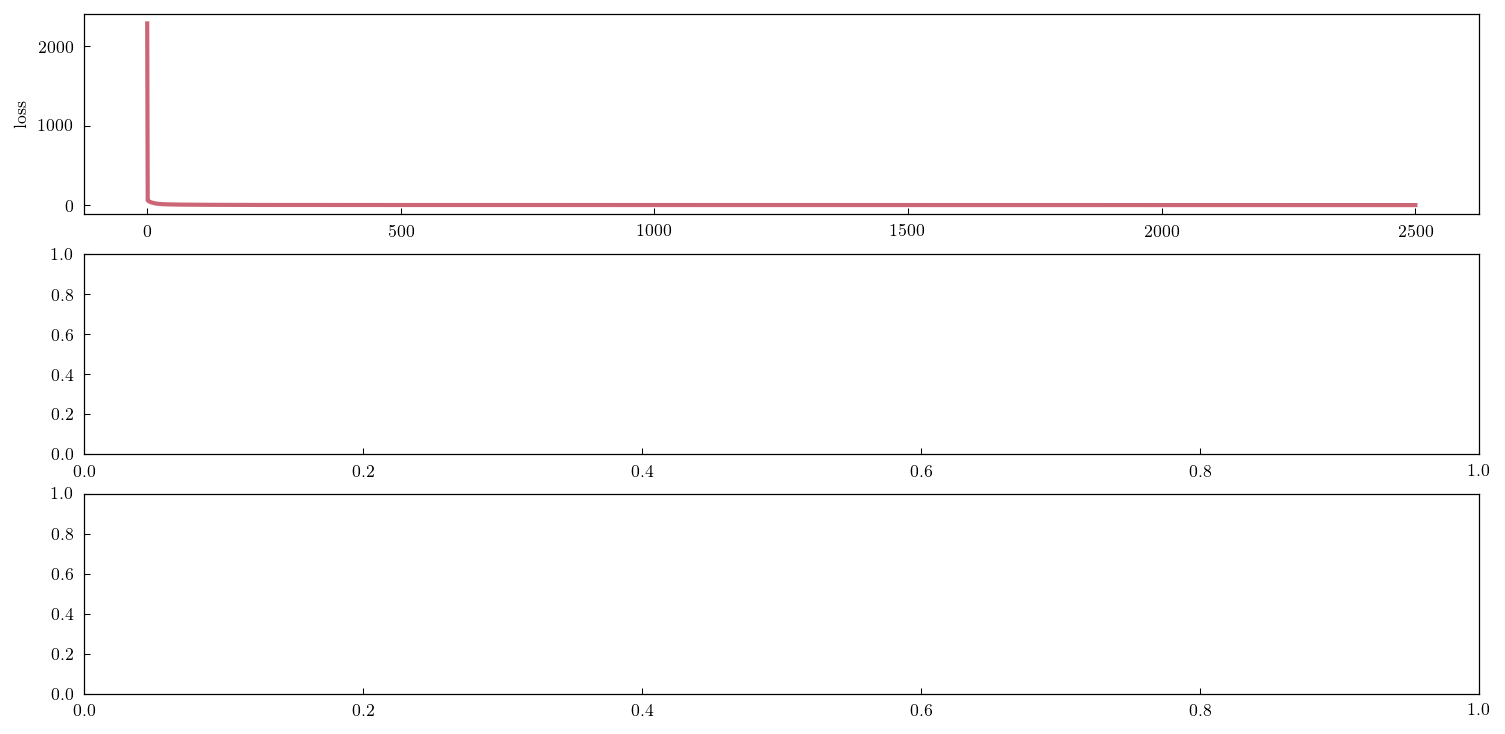

In [19]:
f, axs = plt.subplots(3, 1, figsize=(12, 6))
axs[0].plot(jnp.asarray(loss_hist) / loss(W, Z), lw=2)
axs[0].set_ylabel("loss")
# axs[1].plot(jnp.asarray(W_hist) / jnp.linalg.norm(W, ord=jnp.inf), lw=2)
# axs[1].set_ylabel("Assignment error")
# axs[2].plot(jnp.asarray(Z_hist) / jnp.linalg.norm(Z), lw=2)
# axs[2].set_ylabel("Centroids error")

In [78]:
print(loss_hist[-1])

6.43585


In [20]:
from itertools import permutations

In [21]:
from scipy.special import factorial

In [22]:
def permMatrices(n):
    x = np.zeros((n, n, factorial(n, exact=True)))
    perms = permutations(range(n))
    for i, p in zip(range(x.shape[-1]), perms):
        x[:, :, i] = np.eye(n)[p, :]
    return x

In [23]:
perms = permMatrices(K)

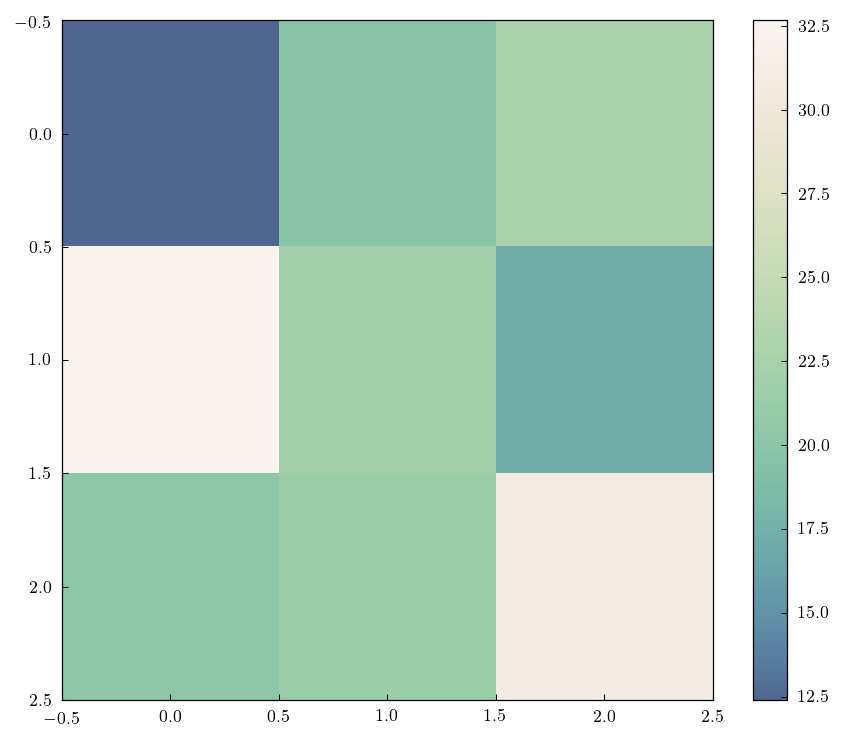

In [24]:
plt.figure(figsize=(7, 6))
plt.imshow(W.T @ What, cmap=cm_seq, aspect="auto", interpolation="none")
plt.colorbar()

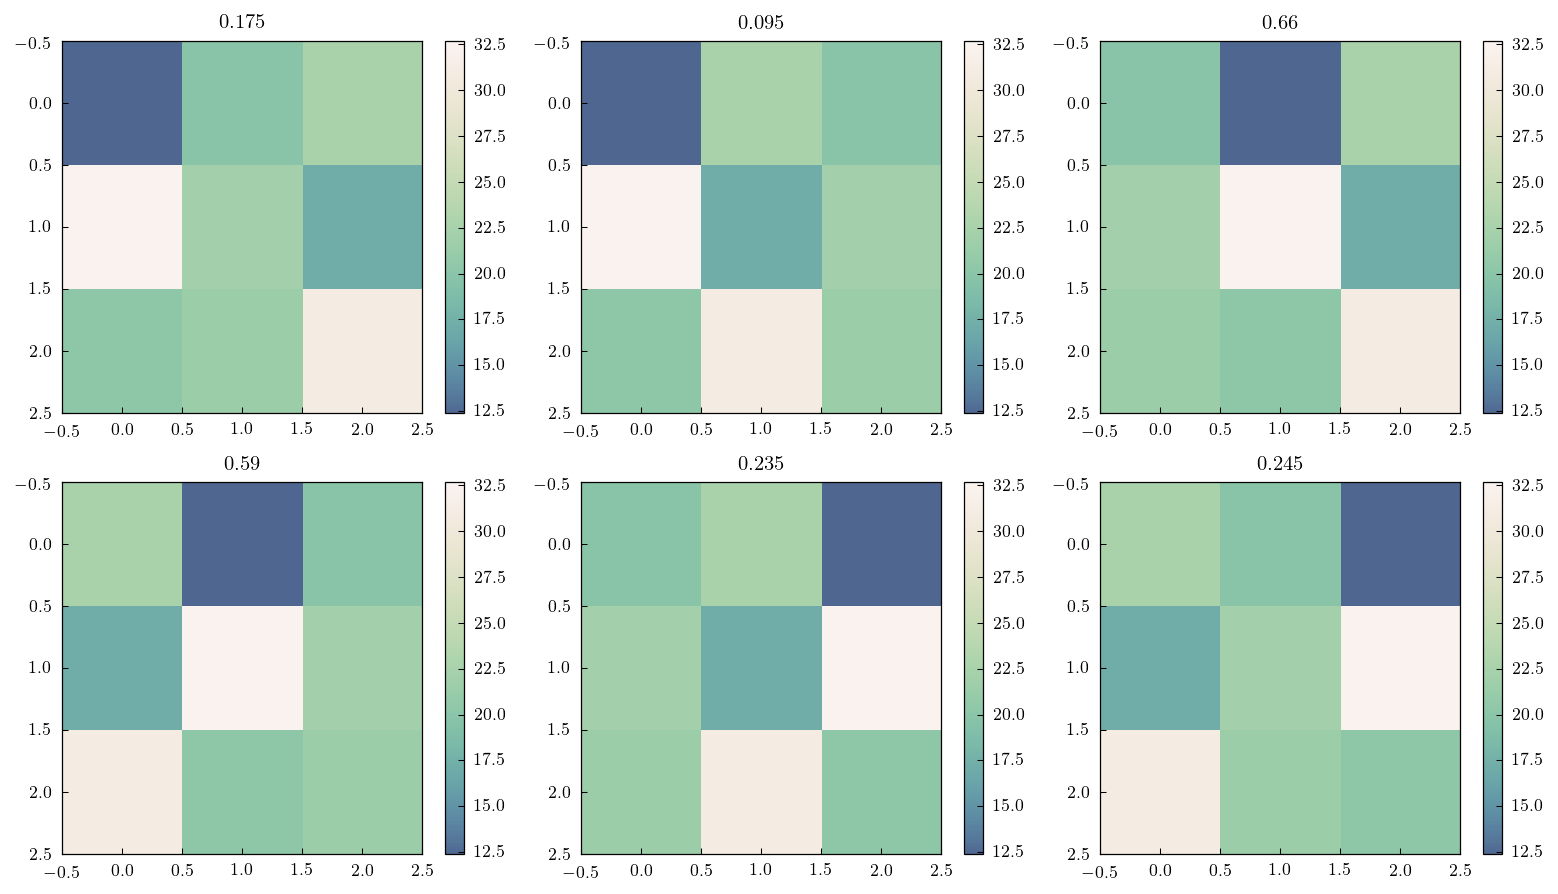

In [26]:
f, axs = plt.subplots(2, 3, figsize=(10.5, 6))
for i, ax in enumerate(axs.flat):
    What_perm = What @ perms[:, :, i]
    h = ax.imshow(W.T @ What_perm, aspect="auto", interpolation="none", cmap=cm_seq)
    est_assignments = np.argmax(What_perm, axis=1)
    accuracy = np.count_nonzero((est_assignments == assignments)) / len(assignments)
    plt.colorbar(h, ax=ax)
    ax.set_title(accuracy)
f.tight_layout()

NameError: name 'perms' is not defined

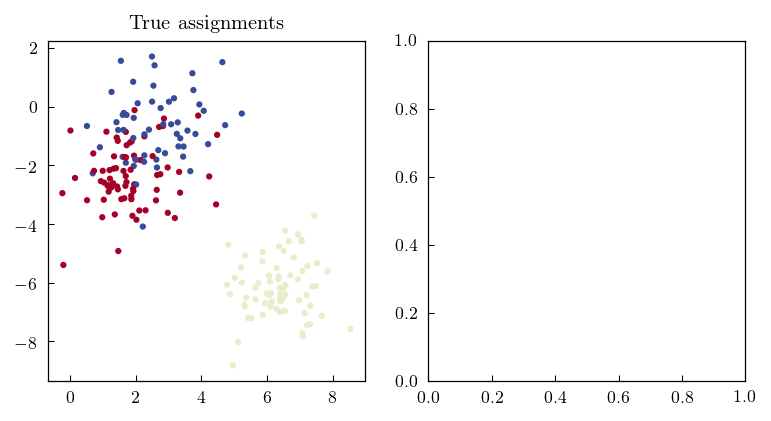

In [14]:
f, (ax0, ax1) = plt.subplots(1, 2, figsize=(6, 3))
ax0.scatter(*X.T, c=assignments, cmap=cm_div)
ax0.set_title("True assignments")
est_assignments = np.argmax(What @ perms[..., 2], axis=1)
ax1.scatter(*X.T, c=est_assignments, cmap=cm_div)
ax1.set_title("Estimated assignments")
f.tight_layout()
print(
    f"Accuracy : {np.count_nonzero(est_assignments == assignments)  / len(assignments) * 100:.1f}%"
)

Accuracy : 17.5%


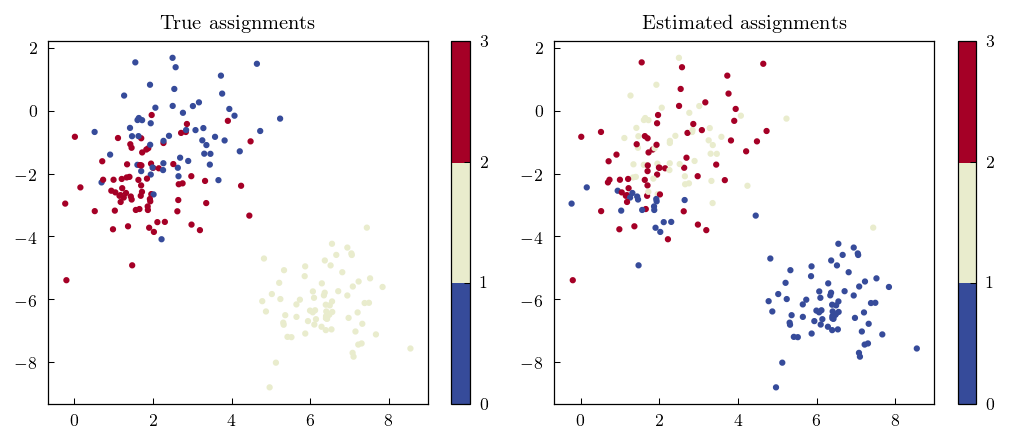

In [34]:
f, (ax0, ax1) = plt.subplots(1, 2, figsize=(7, 3))
h0 = ax0.scatter(*X.T, c=assignments, cmap=cm_div, norm=norm)
ax0.set_title("True assignments")
plt.colorbar(h0, ax=ax0)
est_assignments = np.argmax(What, axis=1)
h1 = ax1.scatter(*X.T, c=est_assignments, cmap=cm_div, norm=norm)
# ax1.plot(*Zhat.T, 'sk')
ax1.set_title("Estimated assignments")
plt.colorbar(h1, ax=ax1)
f.tight_layout()
print(
    f"Accuracy : {np.count_nonzero(est_assignments == assignments)  / len(assignments) * 100:.1f}%"
)


# Loss with transition matrix

In [13]:
# double well data
double_well_data = np.load("/project2/roux/scguo/toy_models/double_well.npy")
print(double_well_data.shape)

(200000000, 3)


In [14]:
# split into a bunch of short trajectories
trajs = [t[:, 1:] for t in np.split(double_well_data, 1000)]

In [41]:
# @jax.jit
def loss_tmat(X, W, Z, tau, lmbda):
    loss = 0
    for (x, w, z) in zip(X, W, Z):
        w0 = w[:-tau]
        wt = w[tau:]
        tmat = jnp.linalg.inv(w0.T @ w0) @ w0.T @ wt
        tmat_loss = jnp.sum(1 / (1 - jnp.diagonal(tmat)))
        loss += (jnp.linalg.norm(w0 @ z - x[:-tau]) ** 2 + lmbda * tmat_loss) / n
    return loss

In [16]:
# def loss_jit(W, Z, tau):

#     def loss_tmat(W, Z, tau):
#         W0 = W[:-tau]
#         Wt = W[tau:]
#         tmat = jnp.linalg.inv(W0.T @ W0) @ W0.T @ Wt
#         tmat_loss = jnp.sum(1 / (1 - jnp.diagonal(tmat)))
#         return jnp.linalg.norm(W0 @ Z - X)**2 / n + lmbda * tmat_loss # + lmbda * jnp.sum(jnp.abs(W0))

#     return jax.jit(loss_jit, static_argnames='tau')

In [19]:
def pgd_tmat(X, What, Zhat, eta=1e-3, max_iter=1000, tau=10, lmbda=0.1):
    """Performed projected gradient descent using a modified loss function which
    includes a penalty from the diagonal elements of the transition matrix.

    Parameters
    ----------
    X : list of ndarray of shape (n_samples, n_features)
        Data array
    What : list of ndarray of shape (n_samples, n_clusters)
        Initial guess for (soft) assignments
    Zhat : ndarray of shape (n_clusters, n_features)
        Initial guess for cluster means
    eta : float
        Step size for gradient descent
    max_iter : int
        Maximum number of PGD steps to perform
    tau : int
        Time lag (in number of frames) for transition matrix
    lmbda : float
        Parameter between 0 and 1 which controls weight of transition matrix loss term
    """
    assert len(X) == len(What)
    assert len(What) == len(Zhat)
    loss_jit = jax.jit(loss_tmat, static_argnames=("tau", "lmbda"))
    grad = jax.grad(loss_jit, argnums=(1, 2))
    grad_jit = jax.jit(grad, static_argnames=("tau", "lmbda"))
    loss_hist = [loss_jit(X, What, Zhat, tau, lmbda)]

    for it in range(max_iter):
        dW, dZ = grad_jit(X, What, Zhat, tau=tau, lmbda=lmbda)

        diff = What - eta * dW
        What = project(jnp.where(diff > 0, x=diff, y=0))
        Zhat -= eta * dZ

        # Bregman divergence update rule
        #         What = project(What * jnp.exp(-eta * dW))
        #         Zhat = Zhat * jnp.exp(-eta * dZ)
        curr_loss = loss_jit(X, What, Zhat, tau, lmbda)
        loss_hist.append(curr_loss)

        if it % 100 == 99:
            print(f"Finished iteration {it + 1}")
            print(f"Loss: {curr_loss}")
    #             print(f"What: {What}\n")

    return What, Zhat, loss_hist

In [20]:
X = trajs[:5]
n = X[0].shape[0]
K = 5
d = X[0].shape[1]
tau = 10
# X = X[:-tau]

In [21]:
key = random.PRNGKey(123)
key, *subkeys = random.split(key, 6)
W0 = random.normal(subkeys[0], shape=(n, K))
Z0 = random.normal(subkeys[1], shape=(K, d))

In [22]:
Z0

DeviceArray([[ 0.45454934, -0.34354013],
             [ 1.2715414 ,  0.08043824],
             [ 1.7775644 ,  0.23463424],
             [-2.0390234 ,  0.22977228],
             [ 0.60258   ,  1.79408   ]], dtype=float32)

In [42]:
loss_jit = jax.jit(loss_tmat, static_argnames=("tau", "lmbda"))
grad = jax.grad(loss_jit, argnums=(1, 2))

In [44]:
What = project(W0)
grad([X], [What], [Z0], tau=10, lmbda=0.1)

TypeError: unsupported operand type(s) for -: 'JVPTracer' and 'list'

In [36]:
loss_jit([X], [What], Z0, tau=10, lmbda=0.2)

TypeError: unsupported operand type(s) for -: 'DynamicJaxprTracer' and 'list'

In [118]:
grad_jit = jax.jit(grad, static_argnames=("tau", "lmbda"))

In [123]:
grad_jit(X, What, Zhat, tau=10, lmbda=0.4)

(DeviceArray([[-2.1714497e+01,  2.6590192e+00, -1.5021328e+01,
                1.1630889e+01,  2.2443188e+01],
              [ 8.0034304e+00, -9.7998720e-01,  5.5367670e+00,
               -4.2865000e+00, -8.2724781e+00],
              [ 1.0371883e+01, -1.2700844e+00,  7.1748643e+00,
               -5.5555243e+00, -1.0719870e+01],
              ...,
              [ 2.3925667e-13,  1.4689193e-11,  3.3537452e-13,
                1.4961937e-12,  2.1361661e-13],
              [ 2.3926412e-13,  1.4689305e-11,  3.3538577e-13,
                1.4962558e-12,  2.1362312e-13],
              [ 2.3926043e-13,  1.4689548e-11,  3.3538444e-13,
                1.4962117e-12,  2.1362216e-13]], dtype=float32),
 DeviceArray([[-1.7470659e+10,  1.8990807e+10],
              [ 2.1433763e+09, -2.3299566e+09],
              [-1.2105290e+10,  1.3159289e+10],
              [ 9.3466276e+09, -1.0159451e+10],
              [ 1.8085958e+10, -1.9660710e+10]], dtype=float32))

In [93]:
epochs = 5000
What = project(W0)
What, Zhat, loss_hist = pgd(What, Z0, 1e-4, epochs)

Finished iteration 1000
Finished iteration 2000
Finished iteration 3000
Finished iteration 4000
Finished iteration 5000


Text(0, 0.5, 'loss')

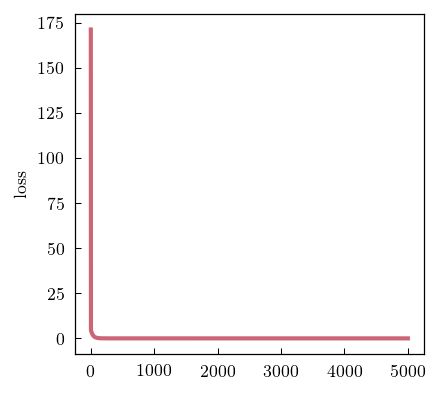

In [94]:
f, ax = plt.subplots(figsize=(3, 3))
ax.plot(jnp.asarray(loss_hist) / n, lw=2)
ax.set_ylabel("loss")

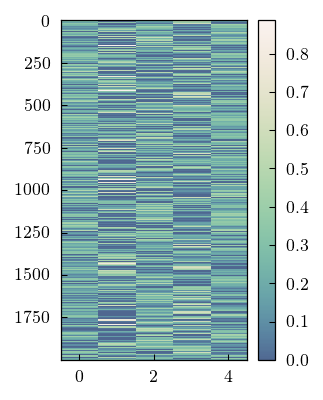

In [95]:
plt.figure(figsize=(2, 3))
plt.imshow(What[::100], aspect="auto", interpolation="none", cmap=cm_seq)
plt.colorbar()

In [97]:
Zhat

DeviceArray([[-1568.5504 ,  1698.7198 ],
             [  191.2258 ,  -207.78319],
             [-1082.5234 ,  1178.5133 ],
             [  846.6754 ,  -906.0072 ],
             [ 1611.8413 , -1764.8284 ]], dtype=float32)

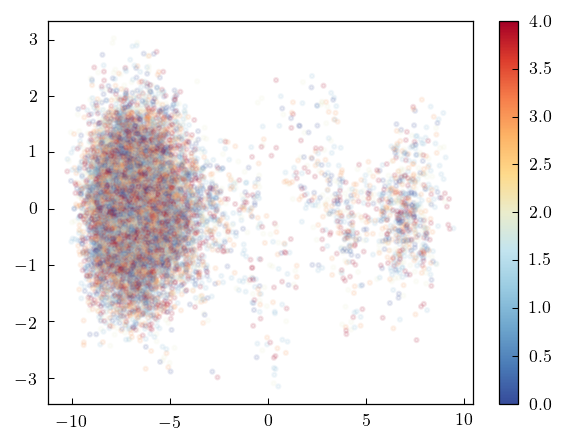

In [98]:
f, ax = plt.subplots(figsize=(4, 3))
est_assignments = np.argmax(What, axis=1)
h = ax.scatter(*X[::10].T, c=est_assignments[::10], cmap=cm_div, alpha=0.1)
# ax.scatter([:, 0], Z0[:, 1], c='k')
cb = plt.colorbar(h, ax=ax)
cb.solids.set(alpha=1)
f.tight_layout()

In [99]:
What.shape

(200000, 5)

In [100]:
Z0.shape

(5, 2)

In [101]:
What = project(W0)
What, Zhat, loss_hist = pgd_tmat(X, What, Z0, 5e-5, 1000)

Finished iteration 100
Loss: 161067.109375
Finished iteration 200
Loss: 111104.3125
Finished iteration 300
Loss: 77007.515625
Finished iteration 400
Loss: 53621.7890625
Finished iteration 500
Loss: 37505.92578125
Finished iteration 600
Loss: 26348.99609375
Finished iteration 700
Loss: 18590.74609375
Finished iteration 800
Loss: 13172.7646484375
Finished iteration 900
Loss: 9373.4892578125
Finished iteration 1000
Loss: 6698.66943359375


In [105]:
loss(What, Zhat)

DeviceArray(6702.995, dtype=float32)

Text(0, 0.5, 'loss')

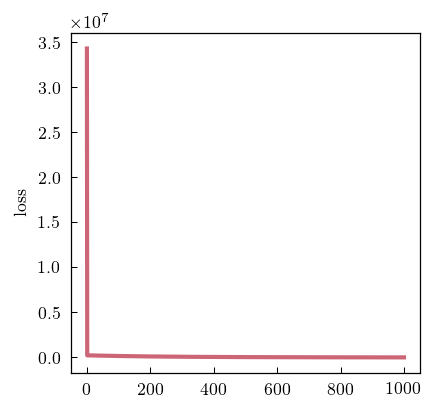

In [102]:
f, ax = plt.subplots(figsize=(3, 3))
ax.plot(jnp.asarray(loss_hist), lw=2)
ax.set_ylabel("loss")

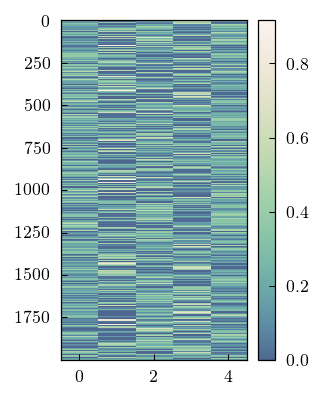

In [103]:
plt.figure(figsize=(2, 3))
plt.imshow(What[::100], aspect="auto", interpolation="none", cmap=cm_seq)
plt.colorbar()

In [69]:
What

DeviceArray([[2.09051728e-01, 2.15002701e-01, 2.38838598e-01,
              0.00000000e+00, 3.37107003e-01],
             [1.42815426e-01, 3.15734029e-01, 1.50961131e-01,
              3.90489399e-01, 0.00000000e+00],
             [1.99002519e-01, 1.05601493e-02, 3.45419735e-01,
              4.61744778e-02, 3.98843139e-01],
             ...,
             [4.02134548e-10, 5.02624691e-01, 4.07307819e-02,
              0.00000000e+00, 4.56644505e-01],
             [1.06531888e-01, 1.85431927e-01, 3.03567886e-01,
              9.35921479e-12, 4.04468328e-01],
             [3.20963040e-02, 4.00172621e-01, 1.05132185e-01,
              4.62598950e-01, 0.00000000e+00]], dtype=float32)

In [68]:
Zhat

DeviceArray([[-783.1163  ,  848.1668  ],
             [  96.040565, -103.67519 ],
             [-539.6327  ,  588.5014  ],
             [ 421.68854 , -452.0715  ],
             [ 805.26886 , -880.4877  ]], dtype=float32)

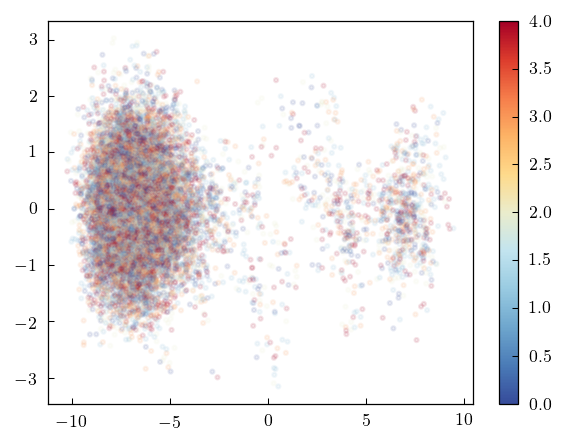

In [104]:
f, ax = plt.subplots(figsize=(4, 3))
est_assignments = np.argmax(What, axis=1)
h = ax.scatter(*X[::10].T, c=est_assignments[::10], cmap=cm_div, alpha=0.1)
# ax.plot(*Zhat.T, 'sk')
cb = plt.colorbar(h, ax=ax)
cb.solids.set(alpha=1)
f.tight_layout()

## With different values of lambda

In [138]:
lambda_vals = [0.2, 0.4, 0.6, 0.8]
What_all, Zhat_all, loss_hist_all = [], [], []
for ll in lambda_vals:
    print(f"Lambda = {ll}")
    What = project(W0)
    What, Zhat, loss_hist = pgd_tmat(X, What, Z0, 5e-5, 1000, lmbda=ll)
    What_all.append(What)
    Zhat_all.append(Zhat)
    loss_hist_all.append(loss_hist)
    print("=================")

Lambda = 0.2
Finished iteration 100
Loss: 161067.109375
Finished iteration 200
Loss: 111104.3125
Finished iteration 300
Loss: 77007.515625
Finished iteration 400
Loss: 53621.7890625
Finished iteration 500
Loss: 37505.92578125
Finished iteration 600
Loss: 26348.99609375
Finished iteration 700
Loss: 18590.74609375
Finished iteration 800
Loss: 13172.7646484375
Finished iteration 900
Loss: 9373.4892578125
Finished iteration 1000
Loss: 6698.66943359375
Lambda = 0.4
Finished iteration 100
Loss: 161067.109375
Finished iteration 200
Loss: 111104.3125
Finished iteration 300
Loss: 77007.515625
Finished iteration 400
Loss: 53621.7890625
Finished iteration 500
Loss: 37505.92578125
Finished iteration 600
Loss: 26348.99609375
Finished iteration 700
Loss: 18590.74609375
Finished iteration 800
Loss: 13172.7646484375
Finished iteration 900
Loss: 9373.4892578125
Finished iteration 1000
Loss: 6698.66943359375
Lambda = 0.6
10 0.6
10 0.6
Finished iteration 100
Loss: 161067.109375
Finished iteration 200
Los

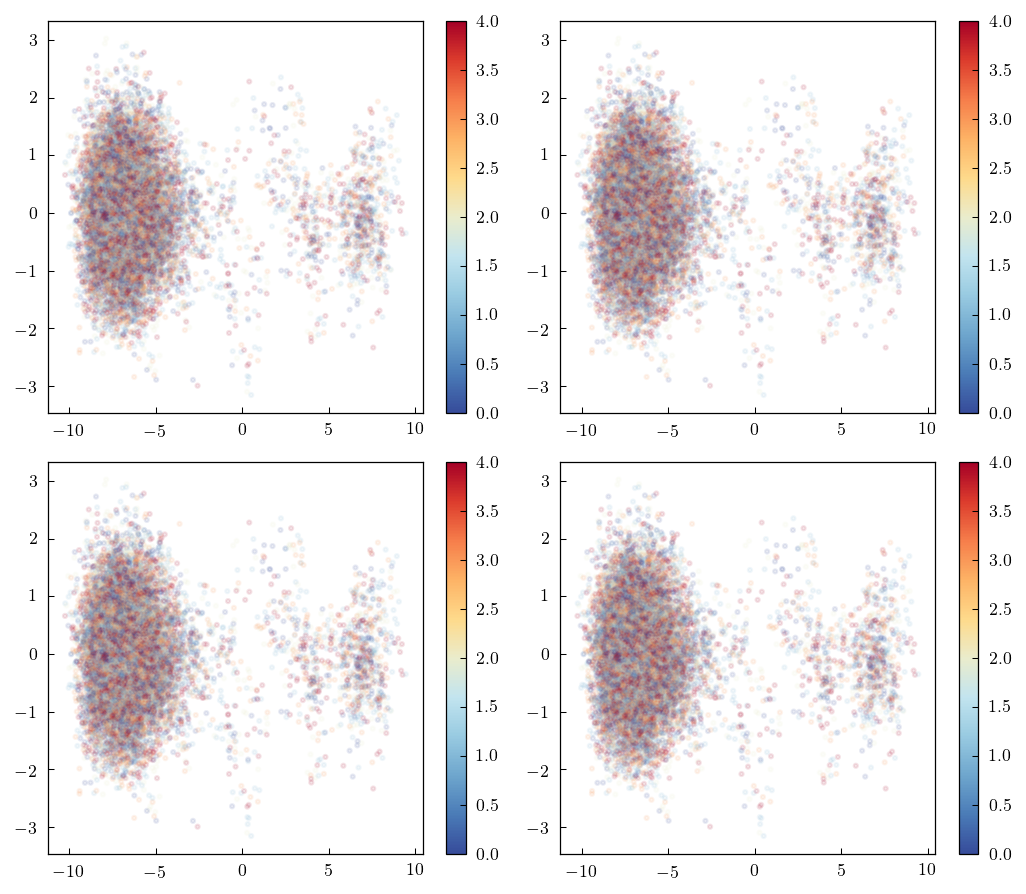

In [142]:
f, axs = plt.subplots(2, 2, figsize=(7, 6))
for What, ax in zip(What_all, axs.flat):
    est_assignments = np.argmax(What, axis=1)
    h = ax.scatter(*X[::10].T, c=est_assignments[::10], cmap=cm_div, alpha=0.1)
    # ax.plot(*Zhat.T, 'sk')
    cb = plt.colorbar(h, ax=ax)
    cb.solids.set(alpha=1)
f.tight_layout()